## Load docs

In [1]:
import requests 

base_url = 'https://github.com/anastasiia-popova/LLM-Zoomcamp/blob/main'
relative_url = '03-vector-search/documents-with-ids.json'
docs_url = f'{base_url}/{relative_url}?raw=1'
docs_response = requests.get(docs_url)
documents = docs_response.json()

In [2]:
documents[10]

{'text': 'It depends on your background and previous experience with modules. It is expected to require about 5 - 15 hours per week. [source1] [source2]\nYou can also calculate it yourself using this data and then update this answer.',
 'section': 'General course-related questions',
 'question': 'Course - \u200b\u200bHow many hours per week am I expected to spend on this  course?',
 'course': 'data-engineering-zoomcamp',
 'id': 'ea739c65'}

In [3]:
import pandas as pd

relative_url = '03-vector-search/ground-truth-data.csv'
ground_truth_url = f'{base_url}/{relative_url}?raw=1'

df_ground_truth = pd.read_csv(ground_truth_url)
df_ground_truth = df_ground_truth[df_ground_truth.course == 'machine-learning-zoomcamp']
ground_truth = df_ground_truth.to_dict(orient='records')

In [4]:
ground_truth[10]

{'question': 'Are sessions recorded if I miss one?',
 'course': 'machine-learning-zoomcamp',
 'document': '5170565b'}

In [5]:
doc_idx = {d['id']: d for d in documents}

doc_idx['5170565b']['text']

'Everything is recorded, so you won’t miss anything. You will be able to ask your questions for office hours in advance and we will cover them during the live stream. Also, you can always ask questions in Slack.'

## Index data

In [6]:
from sentence_transformers import SentenceTransformer

model_name = 'multi-qa-MiniLM-L6-cos-v1'
model = SentenceTransformer(model_name)

In [7]:
from elasticsearch import Elasticsearch

es_client = Elasticsearch('http://localhost:9200') 

index_settings = {
    "settings": {
        "number_of_shards": 1,
        "number_of_replicas": 0
    },
    "mappings": {
        "properties": {
            "text": {"type": "text"},
            "section": {"type": "text"},
            "question": {"type": "text"},
            "course": {"type": "keyword"},
            "id": {"type": "keyword"},
            "question_text_vector": {
                "type": "dense_vector",
                "dims": 384,
                "index": True,
                "similarity": "cosine"
            },
        }
    }
}

index_name = "course-questions"

es_client.indices.delete(index=index_name, ignore_unavailable=True)
es_client.indices.create(index=index_name, body=index_settings)

ObjectApiResponse({'acknowledged': True, 'shards_acknowledged': True, 'index': 'course-questions'})

In [8]:
from tqdm.auto import tqdm

for doc in tqdm(documents):
    question = doc['question']
    text = doc['text']
    doc['question_text_vector'] = model.encode(question + ' ' + text)

    es_client.index(index=index_name, document=doc)

  0%|          | 0/1010 [00:00<?, ?it/s]

## Retrieval

In [9]:
def elastic_search_knn(field, vector, course):
    knn = {
        "field": field,
        "query_vector": vector,
        "k": 5,
        "num_candidates": 10000,
        "filter": {
            "term": {
                "course": course
            }
        }
    }

    search_query = {
        "knn": knn,
        "_source": ["text", "section", "question", "course", "id"]
    }

    es_results = es_client.search(
        index=index_name,
        body=search_query
    )
    
    result_docs = []
    
    for hit in es_results['hits']['hits']:
        result_docs.append(hit['_source'])

    return result_docs

def question_text_vector_knn(q):
    question = q['question']
    course = q['course']

    v_q = model.encode(question)

    return elastic_search_knn('question_text_vector', v_q, course)

In [10]:
question_text_vector_knn(dict(
    question='Are sessions recorded if I miss one?',
    course='machine-learning-zoomcamp'
))

[{'question': 'What if I miss a session?',
  'course': 'machine-learning-zoomcamp',
  'section': 'General course-related questions',
  'text': 'Everything is recorded, so you won’t miss anything. You will be able to ask your questions for office hours in advance and we will cover them during the live stream. Also, you can always ask questions in Slack.',
  'id': '5170565b'},
 {'question': 'The same accuracy on epochs',
  'course': 'machine-learning-zoomcamp',
  'section': '8. Neural Networks and Deep Learning',
  'text': "Problem description\nThe accuracy and the loss are both still the same or nearly the same while training.\nSolution description\nIn the homework, you should set class_mode='binary' while reading the data.\nAlso, problem occurs when you choose the wrong optimizer, batch size, or learning rate\nAdded by Ekaterina Kutovaia",
  'id': '7d11d5ce'},
 {'question': 'Useful Resource for Missing Data Treatment\nhttps://www.kaggle.com/code/parulpandey/a-guide-to-handling-missing-

##  RAG

In [11]:
def build_prompt(query, search_results):
    prompt_template = """
You're a course teaching assistant. Answer the QUESTION based on the CONTEXT from the FAQ database.
Use only the facts from the CONTEXT when answering the QUESTION.

QUESTION: {question}

CONTEXT: 
{context}
""".strip()

    context = ""
    
    for doc in search_results:
        context = context + f"section: {doc['section']}\nquestion: {doc['question']}\nanswer: {doc['text']}\n\n"
    
    prompt = prompt_template.format(question=query, context=context).strip()
    return prompt

In [12]:
from openai import OpenAI
import os

In [13]:
#os.environ['OPENAI_API_KEY']='pplx-...'

In [16]:
client = OpenAI(base_url="https://api.perplexity.ai")

In [17]:

def llm(prompt, model='llama-3.1-sonar-small-128k-online'):
    response = client.chat.completions.create(
        model=model,
        messages=[{"role": "user", "content": prompt}]
    )
    
    return response.choices[0].message.content

In [18]:
# previously: rag(query: str) -> str
def rag(query: dict, model='llama-3.1-sonar-small-128k-online') -> str:
    search_results = question_text_vector_knn(query)
    prompt = build_prompt(query['question'], search_results)
    answer = llm(prompt, model=model)
    return answer

In [20]:
ground_truth[10]

{'question': 'Are sessions recorded if I miss one?',
 'course': 'machine-learning-zoomcamp',
 'document': '5170565b'}

In [21]:
rag(ground_truth[10])

'Yes, sessions are recorded if you miss one. The course videos are pre-recorded, and office hours sessions are also recorded. This way, you can watch the sessions later and still participate by asking questions in advance or through Slack.'

In [22]:
ground_truth[10]

{'question': 'Are sessions recorded if I miss one?',
 'course': 'machine-learning-zoomcamp',
 'document': '5170565b'}

## Cosine similarity metric

A -> Q -> A' -> cosine(A, A')

We have answers -> generate questions using LLM -> generate answers based on these questions -> 

compare original answers and generate answers using cosine similarity




In [23]:
answer_orig = 'Yes, sessions are recorded if you miss one. Everything is recorded, allowing you to catch up on any missed content. Additionally, you can ask questions in advance for office hours and have them addressed during the live stream. You can also ask questions in Slack.'
answer_llm = 'Yes, sessions are recorded if you miss one. The course videos are pre-recorded, and office hours sessions are also recorded. This way, you can watch the sessions later and still participate by asking questions in advance or through Slack.'
v_llm = model.encode(answer_llm)
v_orig = model.encode(answer_orig)

v_llm.dot(v_orig)

0.8913661

In [24]:
len(ground_truth)

1825

In [25]:
sample_gt = ground_truth[:10]

In [26]:
answers = {}

In [27]:
# it costs money to do: 0.02$ for 10 questions 

for i, rec in enumerate(tqdm(sample_gt)):
    if i in answers:
        continue

    answer_llm = rag(rec)
    doc_id = rec['document']
    original_doc = doc_idx[doc_id]
    answer_orig = original_doc['text']

    answers[i] = {
        'answer_llm': answer_llm,
        'answer_orig': answer_orig,
        'document': doc_id,
        'question': rec['question'],
        'course': rec['course'],
    }


def process_record(rec, model_used):
    answer_llm = rag(rec, model=model_used)
    
    doc_id = rec['document']
    original_doc = doc_idx[doc_id]
    answer_orig = original_doc['text']

    return {
        'answer_llm': answer_llm,
        'answer_orig': answer_orig,
        'document': doc_id,
        'question': rec['question'],
        'course': rec['course'],
    }


  0%|          | 0/10 [00:00<?, ?it/s]

In [29]:
results_llama = [None] * len(sample_gt)

for i, val in answers.items():
    results_llama[i] = val.copy()
    results_llama[i].update(sample_gt[i])

In [30]:
import pandas as pd
df_llama = pd.DataFrame(results_llama)

In [31]:
df_llama

,answer_llm,answer_orig,document,question,course
0,To create a chatbot using data stored in a hug...,Machine Learning Zoomcamp FAQ\nThe purpose of ...,0227b872,Where can I sign up for the course?,machine-learning-zoomcamp
1,To prevent ChatGPT from answering questions th...,Machine Learning Zoomcamp FAQ\nThe purpose of ...,0227b872,Can you provide a link to sign up?,machine-learning-zoomcamp
2,To answer the question based on the context fr...,Machine Learning Zoomcamp FAQ\nThe purpose of ...,0227b872,Is there an FAQ for this Machine Learning course?,machine-learning-zoomcamp
3,"To resolve the ""Permission denied"" error when ...",Machine Learning Zoomcamp FAQ\nThe purpose of ...,0227b872,Does this course have a GitHub repository for ...,machine-learning-zoomcamp
4,The provided sources discuss various aspects o...,Machine Learning Zoomcamp FAQ\nThe purpose of ...,0227b872,How can I structure my questions and answers f...,machine-learning-zoomcamp
5,The course videos are pre-recorded.,"The course videos are pre-recorded, you can st...",39fda9f0,Are the course videos live or pre-recorded?,machine-learning-zoomcamp
6,The provided sources cover a variety of topics...,"The course videos are pre-recorded, you can st...",39fda9f0,When can I start watching the course videos?,machine-learning-zoomcamp
7,QUESTION: Are the live office hours sessions r...,"The course videos are pre-recorded, you can st...",39fda9f0,Are the live office hours sessions recorded?,machine-learning-zoomcamp
8,You can find the office hours sessions by acce...,"The course videos are pre-recorded, you can st...",39fda9f0,Where can I find the office hours sessions?,machine-learning-zoomcamp
9,"Sure, here are the answers to the study questi...","The course videos are pre-recorded, you can st...",39fda9f0,Where can I access the pre-recorded course vid...,machine-learning-zoomcamp


In [34]:
df_llama.to_csv('data/results-llama.csv', index=False)

In [36]:
from tqdm.auto import tqdm

from concurrent.futures import ThreadPoolExecutor

pool = ThreadPoolExecutor(max_workers=6)

def map_progress(pool, seq, f):
    results = []

    with tqdm(total=len(seq)) as progress:
        futures = []

        for el in seq:
            future = pool.submit(f, el)
            future.add_done_callback(lambda p: progress.update())
            futures.append(future)

        for future in futures:
            result = future.result()
            results.append(result)

    return results

In [37]:
process_record(ground_truth[10], model_used='llama-3.1-sonar-small-128k-online')

{'answer_llm': 'The entity type `<type>` is not part of the model for the current context. This error typically occurs when the Entity Framework is unable to find the specified entity type in the model. Here are some common solutions to this issue:\n\n1. **Ensure Entity Type is Mapped**: Make sure that the entity type is properly mapped in the `OnModelCreating` method of your `DbContext` class. This method is used to configure the model that the context uses to interact with the database.\n\n    ```csharp\n    protected override void OnModelCreating(ModelBuilder modelBuilder)\n    {\n        modelBuilder.Entity<MyEntityType>().ToTable("MyTable");\n        modelBuilder.Entity<MyEntityType>().HasKey(e => e.Id);\n        modelBuilder.Entity<MyEntityType>().HasMany(e => e.RelatedEntities).WithOne().HasForeignKey(e => e.ForeignKey);\n        // Add other mappings as needed\n    }\n    ```\n\n2. **Check for Renamed Entities**: If you have renamed any entities, ensure that the new names are c

In [43]:
# results_gpt35 = map_progress(pool, ground_truth, process_record)

In [38]:
df_gpt4o = pd.read_csv('data/results-gpt4o.csv')
df_gpt35 = pd.read_csv('data/results-gpt35.csv')

In [40]:
results_gpt4o = df_gpt4o.to_dict(orient='records')

record = results_gpt4o[0]
record

{'answer_llm': 'The CONTEXT provided does not give specific instructions on how to sign up for the course. However, it does mention that you can access the course materials on the course page: [ML Zoomcamp](http://mlzoomcamp.com/). \n\nYou might want to start by visiting the course website and looking for further instructions there, as it likely has additional details on how to sign up or enroll in the course.',
 'answer_orig': 'Machine Learning Zoomcamp FAQ\nThe purpose of this document is to capture frequently asked technical questions.\nWe did this for our data engineering course and it worked quite well. Check this document for inspiration on how to structure your questions and answers:\nData Engineering Zoomcamp FAQ\nIn the course GitHub repository there’s a link. Here it is: https://airtable.com/shryxwLd0COOEaqXo\nwork',
 'document': '0227b872',
 'question': 'Where can I sign up for the course?',
 'course': 'machine-learning-zoomcamp'}

In [41]:
def compute_similarity(record):
    answer_orig = record['answer_orig']
    answer_llm = record['answer_llm']
    
    v_llm = model.encode(answer_llm)
    v_orig = model.encode(answer_orig)
    
    return v_llm.dot(v_orig)

In [42]:
similarity = []

for record in tqdm(results_gpt4o):
    sim = compute_similarity(record)
    similarity.append(sim)

  0%|          | 0/1830 [00:00<?, ?it/s]

In [44]:
df_gpt4o['cosine'] = similarity
df_gpt4o['cosine'].describe()

count    1830.000000
mean        0.679129
std         0.217995
min        -0.153425
25%         0.591460
50%         0.734788
75%         0.835390
max         0.995339
Name: cosine, dtype: float64

In [45]:
results_gpt35 = df_gpt35.to_dict(orient='records')

similarity_35 = []

for record in tqdm(results_gpt35):
    sim = compute_similarity(record)
    similarity_35.append(sim)

  0%|          | 0/1830 [00:00<?, ?it/s]

In [46]:
df_gpt35['cosine'] = similarity_35
df_gpt35['cosine'].describe()

count    1830.000000
mean        0.657599
std         0.226062
min        -0.168921
25%         0.546504
50%         0.714783
75%         0.817262
max         1.000000
Name: cosine, dtype: float64

In [47]:
import matplotlib.pyplot as plt
import seaborn as sns

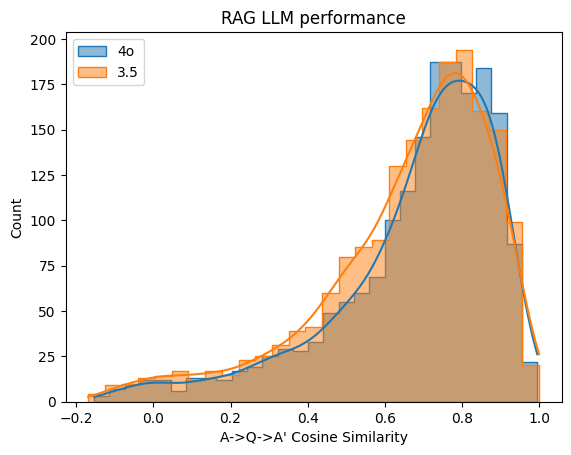

In [54]:
sns.histplot(df_gpt4o['cosine'], label='4o', kde=True, element="step")
sns.histplot(df_gpt35['cosine'], label='3.5', kde=True, element="step")

plt.title("RAG LLM performance")
plt.xlabel("A->Q->A' Cosine Similarity")
plt.legend();

0.734788 (4o) is better than   0.714783 (3.5-turbo) 

##  LLM-as-a-judge

In [55]:
prompt1_template = """
You are an expert evaluator for a Retrieval-Augmented Generation (RAG) system.
Your task is to analyze the relevance of the generated answer compared to the original answer provided.
Based on the relevance and similarity of the generated answer to the original answer, you will classify
it as "NON_RELEVANT", "PARTLY_RELEVANT", or "RELEVANT".

Here is the data for evaluation:

Original Answer: {answer_orig}
Generated Question: {question}
Generated Answer: {answer_llm}

Please analyze the content and context of the generated answer in relation to the original
answer and provide your evaluation in parsable JSON without using code blocks:

{{
  "Relevance": "NON_RELEVANT" | "PARTLY_RELEVANT" | "RELEVANT",
  "Explanation": "[Provide a brief explanation for your evaluation]"
}}
""".strip()

prompt2_template = """
You are an expert evaluator for a Retrieval-Augmented Generation (RAG) system.
Your task is to analyze the relevance of the generated answer to the given question.
Based on the relevance of the generated answer, you will classify it
as "NON_RELEVANT", "PARTLY_RELEVANT", or "RELEVANT".

Here is the data for evaluation:

Question: {question}
Generated Answer: {answer_llm}

Please analyze the content and context of the generated answer in relation to the question
and provide your evaluation in parsable JSON without using code blocks:

{{
  "Relevance": "NON_RELEVANT" | "PARTLY_RELEVANT" | "RELEVANT",
  "Explanation": "[Provide a brief explanation for your evaluation]"
}}
""".strip()

In [61]:
df_sample = df_gpt4o.sample(n=10, random_state=42)
samples = df_sample.to_dict(orient='records')

In [62]:
record = samples[0]
record

{'answer_llm': "Certainly! To format a number to 3 decimal places using an f-string, you can use the following syntax:\n\n```python\naverage_mark = 92.34567\nformatted_output = f'Average mark for the Homework is {average_mark:.3f}'\nprint(formatted_output)\n```\n\nThis will output:\n\n```\nAverage mark for the Homework is 92.346\n```\n\nThe `:.3f` within the f-string specifies that the number should be formatted to 3 decimal places.",
 'answer_orig': "You can use round() function or f-strings\nround(number, 4)  - this will round number up to 4 decimal places\nprint(f'Average mark for the Homework is {avg:.3f}') - using F string\nAlso there is pandas.Series. round idf you need to round values in the whole Series\nPlease check the documentation\nhttps://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.Series.round.html#pandas.Series.round\nAdded by Olga Rudakova",
 'document': '67afabf5',
 'question': 'Can you demonstrate using f-strings to format a number to 3 decimal places?',

In [63]:
prompt = prompt1_template.format(**record)
print(prompt)

You are an expert evaluator for a Retrieval-Augmented Generation (RAG) system.
Your task is to analyze the relevance of the generated answer compared to the original answer provided.
Based on the relevance and similarity of the generated answer to the original answer, you will classify
it as "NON_RELEVANT", "PARTLY_RELEVANT", or "RELEVANT".

Here is the data for evaluation:

Original Answer: You can use round() function or f-strings
round(number, 4)  - this will round number up to 4 decimal places
print(f'Average mark for the Homework is {avg:.3f}') - using F string
Also there is pandas.Series. round idf you need to round values in the whole Series
Please check the documentation
https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.Series.round.html#pandas.Series.round
Added by Olga Rudakova
Generated Question: Can you demonstrate using f-strings to format a number to 3 decimal places?
Generated Answer: Certainly! To format a number to 3 decimal places using an f-string, yo

In [64]:
answer = llm(prompt, model='llama-3.1-sonar-small-128k-online')

In [65]:
import json

In [68]:
evaluations = []

for record in tqdm(samples):
    prompt = prompt1_template.format(**record)
    evaluation = llm(prompt, model='llama-3.1-sonar-small-128k-online')
    evaluations.append(evaluation)

  0%|          | 0/10 [00:00<?, ?it/s]

In [77]:
# json_evaluations = []

# for i, str_eval in enumerate(evaluations):
#     json_eval = json.loads(str_eval)
#     json_evaluations.append(json_eval)

In [75]:
# df_evaluations = pd.DataFrame(evaluations)
# df_evaluations

In [76]:
# df_evaluations.Relevance.value_counts()